In [2]:
# On affiche les graphiques dans le notebook en statique
%matplotlib inline

In [3]:
"""
code du lightgbm repris (et adapté) de :
Lien : https://www.kaggle.com/code/jsaguiar/lightgbm-7th-place-solution

KAGGLE HOME CREDIT DEFAULT RISK COMPETITION
Adapted from one of the models used in 7th place solution ensemble.
For more details about our solution please check this discussion:
https://www.kaggle.com/c/home-credit-default-risk/discussion/64580

Another similar version is also available at GitHub:
https://github.com/js-aguiar/home-credit-default-competition

This model uses LightGBM with goss and label encode for the application's 
categorical features. Other tables are using one-hot encode with mean, 
sum and a few different functions to aggregate. The main ideia was to add 
more time related features like last application and last X months aggregations.
There are also aggregations for specific loan types and status as well as
ratios between tables. Configurations are in line 785
"""

import os
import gc
import numpy as np
import pandas as pd
import joblib
import copy
import warnings
import lightgbm as lgb
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
from sklearn.inspection import permutation_importance


warnings.simplefilter(action="ignore", category=FutureWarning)
## np.warnings.filterwarnings("ignore", r"All-NaN (slice|axis) encountered")
np.seterr(all="ignore", invalid="ignore")

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [4]:
from src.p7_full_kernel import get_full_data, kfold_lightgbm_sklearn
from src.p7_simple_kernel import get_simple_data
from src.p7_simple_kernel import CONFIG_SIMPLE
from src.p7_simple_kernel import get_memory_consumed
from src.p7_feature_selection import DataSelector
from src.p7_simple_kernel import LIGHTGBM_PARAMS_SIMPLE
from src.p7_evaluate import lgb_cross_evaluate
from src.p7_util import timer
from src.p7_constantes import (
    NUM_THREADS,
    DATA_BASE,
    DATA_INTERIM,
)

%load_ext autoreload
%autoreload 2
#autoreload 2 = Reload all modules (except those excluded by %aimport)
# every time before executing the Python code typed.

# Simple Kernel (OHE)

## Lescture des données issues du kernel

In [5]:
train = pd.read_csv(os.path.join(DATA_INTERIM, "v0_train.csv"))
print("Train :", train.shape)
test = pd.read_csv(os.path.join(DATA_INTERIM, "v0_test.csv"))
print("Test :", test.shape)

Train : (230633, 790)
Test : (76878, 790)


## Elimination des Features de variance nulle

In [6]:
ds = DataSelector(train, test)

In [7]:
_ = ds.drop_null_std()

33 features de variance nulle suppimées dans Train et Test
Nouvelle taille du jeu de Train : (230633, 757), 1123 Mo


In [8]:
ds.save_data("v1_train.csv", "v1_test.csv")

Le fichier data/interim/v1_train.csv existe déjà
Le fichier data/interim/v1_test.csv existe déjà
Sauvegarde des données non effectuée. Modifiez les noms de fichier ou forcer avec repace=True


## Features permutation  (test informatique de base)

In [9]:
df = ds.train
# lgb_cross_evaluate(df, params=LIGHTGBM_PARAMS_SIMPLE)

In [10]:
def check_df(X):
    print("Valeurs infinies :\n", np.isinf(X).sum())
    print(
        "Valeurs non numériques :\n",
        X.applymap(lambda x: not isinstance(x, (int, float))).sum(),
    )
    return

In [11]:
features = df.columns.tolist()
features.remove("TARGET")
features.remove("SK_ID_CURR")
X = df[features]
y = df["TARGET"]
X.shape

(230633, 755)

In [12]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

In [13]:
# [TODO] Voir la taille mémoire et la possibilité de faire lgbClassifier ou lgb si bool ou int8 ou int
# Convertir les bool en int
var_bool = df.select_dtypes("bool").columns
len(var_bool)

136

In [14]:
df.loc[:, var_bool] = df.loc[:, var_bool].astype(int)
X.loc[:, var_bool] = X.loc[:, var_bool].astype(int)

D:\TEMP\ipykernel_29640\3660239901.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[var_bool] = X[var_bool].astype(int)


In [15]:
get_memory_consumed(df)

Taille mémoire du DataFrame : 1212 Mo


1212

In [17]:
LIGHTGBM_PARAMS_SIMPLE

{'n_estimators': 10000,
 'learning_rate': 0.02,
 'num_leaves': 34,
 'colsample_bytree': 0.9497036,
 'subsample': 0.8715623,
 'max_depth': 8,
 'reg_alpha': 0.041545473,
 'reg_lambda': 0.0735294,
 'min_split_gain': 0.0222415,
 'min_child_weight': 39.3259775,
 'silent': -1,
 'verbose': -1}

Obtenir un modèle fitté (et bon normalement)

In [18]:
params = {
    "random_state": 42,
    "nthread": 16,
}
clf = LGBMClassifier(**{**params, **LIGHTGBM_PARAMS_SIMPLE})

clf.fit(
    X_train,
    y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],
    eval_metric="auc",
    # verbose=200,
    callbacks=[lgb.early_stopping(50)],
)

"""oof_preds[valid_idx] = clf.predict_proba(
    valid_x, num_iteration=clf.best_iteration_
)[:, 1]"""

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1284]	training's auc: 0.894863	training's binary_logloss: 0.192957	valid_1's auc: 0.784343	valid_1's binary_logloss: 0.238391


'oof_preds[valid_idx] = clf.predict_proba(\n    valid_x, num_iteration=clf.best_iteration_\n)[:, 1]'

In [19]:
clf.best_iteration_

1284

In [20]:
params = clf.get_params()
params["n_estimators"] = clf.best_iteration_

In [21]:
clf = LGBMClassifier(**params)

clf.fit(
    X_train,
    y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],
    eval_metric="auc",
    # verbose=200,
    callbacks=[lgb.early_stopping(50)],
)

Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1284]	training's auc: 0.894863	training's binary_logloss: 0.192957	valid_1's auc: 0.784343	valid_1's binary_logloss: 0.238391


LGBMClassifier(colsample_bytree=0.9497036, learning_rate=0.02, max_depth=8,
               min_child_weight=39.3259775, min_split_gain=0.0222415,
               n_estimators=1284, nthread=16, num_leaves=34, random_state=42,
               reg_alpha=0.041545473, reg_lambda=0.0735294, silent=-1,
               subsample=0.8715623, verbose=-1)

Permutation

In [22]:
fitted_clf = copy.deepcopy(clf)

In [ ]:
result = permutation_importance(
    fitted_clf, X_val, y_val, n_repeats=3, random_state=42, n_jobs=16
)

In [ ]:
len(result)

3

In [ ]:
result.keys()

dict_keys(['importances_mean', 'importances_std', 'importances'])

In [ ]:
sorted_importances_idx = result.importances_mean.argsort()
importances = pd.DataFrame(
    result.importances[sorted_importances_idx].T,
    columns=X.columns[sorted_importances_idx],
)

importances.head()

,PREV_CNT_PAYMENT_MEAN,INSTAL_AMT_PAYMENT_MEAN,INCOME_CREDIT_PERC,PREV_NAME_YIELD_GROUP_low_action_MEAN,PREV_AMT_DOWN_PAYMENT_MAX,CC_CNT_DRAWINGS_CURRENT_MEAN,ACTIVE_DAYS_CREDIT_ENDDATE_MIN,PREV_NAME_CONTRACT_STATUS_Canceled_MEAN,INSTAL_AMT_PAYMENT_MAX,ACTIVE_AMT_CREDIT_SUM_LIMIT_SUM,...,INSTAL_DPD_MEAN,OWN_CAR_AGE,PAYMENT_RATE,CODE_GENDER,DAYS_EMPLOYED,INSTAL_AMT_PAYMENT_SUM,AMT_GOODS_PRICE,EXT_SOURCE_1,EXT_SOURCE_3,EXT_SOURCE_2
0,-0.000139,-0.000208,-0.000156,-0.000191,-0.000139,-0.000052,0.000069,-0.000087,-0.000052,-0.000069,...,-0.000017,0.000208,0.000295,0.000208,0.000451,0.000364,0.000468,0.000416,0.000624,0.001231
1,-0.000191,-0.000260,-0.000104,-0.000173,-0.000121,-0.000156,-0.000208,-0.000087,-0.000104,-0.000121,...,0.000277,0.000191,0.000035,0.000156,0.000087,0.000191,0.000104,0.000555,0.000746,0.000867
2,-0.000364,-0.000225,-0.000156,-0.000017,-0.000069,-0.000104,-0.000173,-0.000121,-0.000121,-0.000087,...,0.000260,0.000139,0.000243,0.000347,0.000191,0.000208,0.000225,0.000468,0.000451,0.001023


In [ ]:
# Top 40 des plus importantes
top = 20
most_important_features = importances.columns[-top:]
len(most_important_features)

20

In [ ]:
most_important_features

Index(['POS_MONTHS_BALANCE_MAX', 'ACTIVE_DAYS_CREDIT_MAX',
       'CLOSED_DAYS_CREDIT_ENDDATE_MAX', 'ACTIVE_AMT_CREDIT_SUM_DEBT_SUM',
       'NAME_EDUCATION_TYPE_Secondarysecondaryspecial',
       'PREV_APP_CREDIT_PERC_MEAN', 'NAME_FAMILY_STATUS_Married',
       'INSTAL_PAYMENT_DIFF_MEAN', 'AMT_ANNUITY', 'DAYS_BIRTH',
       'INSTAL_DPD_MEAN', 'OWN_CAR_AGE', 'PAYMENT_RATE', 'CODE_GENDER',
       'DAYS_EMPLOYED', 'INSTAL_AMT_PAYMENT_SUM', 'AMT_GOODS_PRICE',
       'EXT_SOURCE_1', 'EXT_SOURCE_3', 'EXT_SOURCE_2'],
      dtype='object')

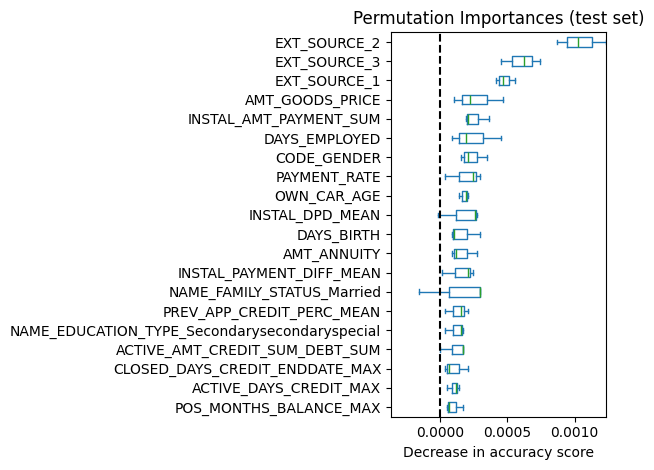

In [ ]:
min_importance = importances.min().min()
max_importance = importances.max().max()
ax = importances[most_important_features].plot.box(vert=False, whis=10)
ax.set_title("Permutation Importances (test set)")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in accuracy score")
ax.set_xlim(min_importance, max_importance)
ax.figure.tight_layout()

In [ ]:
# Top 40 des moins importantes
bottom = top
less_important_features = importances.columns[:bottom]
less_important_features

Index(['PREV_CNT_PAYMENT_MEAN', 'INSTAL_AMT_PAYMENT_MEAN',
       'INCOME_CREDIT_PERC', 'PREV_NAME_YIELD_GROUP_low_action_MEAN',
       'PREV_AMT_DOWN_PAYMENT_MAX', 'CC_CNT_DRAWINGS_CURRENT_MEAN',
       'ACTIVE_DAYS_CREDIT_ENDDATE_MIN',
       'PREV_NAME_CONTRACT_STATUS_Canceled_MEAN', 'INSTAL_AMT_PAYMENT_MAX',
       'ACTIVE_AMT_CREDIT_SUM_LIMIT_SUM', 'PREV_RATE_DOWN_PAYMENT_MEAN',
       'CC_AMT_RECEIVABLE_PRINCIPAL_MEAN', 'APPROVED_APP_CREDIT_PERC_MIN',
       'APPROVED_AMT_ANNUITY_MEAN', 'APPROVED_AMT_ANNUITY_MIN',
       'BURO_DAYS_CREDIT_UPDATE_MEAN', 'CC_AMT_CREDIT_LIMIT_ACTUAL_SUM',
       'APPROVED_CNT_PAYMENT_MEAN', 'APPROVED_CNT_PAYMENT_SUM',
       'REFUSED_DAYS_DECISION_MIN'],
      dtype='object')

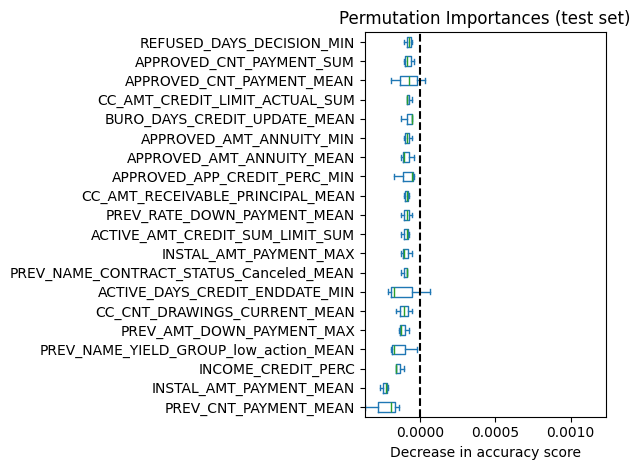

In [ ]:
ax = importances[less_important_features].plot.box(vert=False, whis=10)
ax.set_title("Permutation Importances (test set)")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in accuracy score")
ax.set_xlim(min_importance, max_importance)
ax.figure.tight_layout()

In [ ]:
"""
[TODO] Faire les graphiques sur le même graphique avec des axes jumeaux
"""

Importances faibles / négatives

In [ ]:
# Moyenne des moyennes
mean_importance = np.mean(result["importances_mean"])
mean_importance

7.435050412647598e-06

In [ ]:
# Importances négatives
importances_mean = pd.DataFrame(
    result["importances_mean"], index=X.columns, columns=["importance"]
)
importances_mean.head()

,importance
CODE_GENDER,0.000237
FLAG_OWN_CAR,0.000012
FLAG_OWN_REALTY,-0.000012
CNT_CHILDREN,0.000006
AMT_INCOME_TOTAL,-0.000029


In [ ]:
negative_features = importances_mean[importances_mean["importance"] < 0].index.tolist()
len(negative_features)

223

In [ ]:
"""
I. Interprétation des Importances 

1) Impact Négatif sur les Performances :
Une importance moyenne négative pour une caractéristique signifie que, 
lorsque les valeurs de cette caractéristique sont permutées (c'est-à-dire réarrangées au hasard), 
les performances du modèle s'améliorent plutôt que de se dégrader. En d'autres termes, 
le modèle se comporte mieux sans la structure d'origine de cette caractéristique.

2) Indicateur de Bruit ou d'Information Trompeuse :
Cela peut indiquer que la caractéristique en question introduit du bruit ou de l'information trompeuse dans le modèle, 
ce qui nuit à la capacité du modèle à faire des prédictions précises. 
En d'autres termes, la caractéristique pourrait être nuisible.

II. Raisons Potentielles

1) Multicolinéarité :
Si la caractéristique est fortement corrélée avec une ou plusieurs autres caractéristiques, 
elle peut introduire de la redondance ou même de la confusion dans le modèle.

2) Caractéristique Non Pertinente :
La caractéristique peut être non pertinente pour la tâche de prédiction, et sa présence peut introduire du bruit.

3) Petite Taille de l'Échantillon.
"""

## Corrélations bivariées

Undersampling (A faire dans l'analmyse exploratoire en fait)

In [24]:
df = ds.train
df.shape

(230633, 757)

In [25]:
from src.p7_missing_values import missing_values_barh

(NONLIVINGAREA_AVG                55.256620
 NONLIVINGAREA_MODE               55.256620
 NONLIVINGAREA_MEDI               55.256620
 EXT_SOURCE_1                     56.290297
 BASEMENTAREA_AVG                 58.640351
                                    ...    
 REFUSED_RATE_DOWN_PAYMENT_MAX    85.379369
 REFUSED_RATE_DOWN_PAYMENT_MIN    85.379369
 REFUSED_AMT_DOWN_PAYMENT_MEAN    85.379369
 REFUSED_AMT_DOWN_PAYMENT_MAX     85.379369
 REFUSED_AMT_DOWN_PAYMENT_MIN     85.379369
 Length: 200, dtype: float64,
 <Figure size 800x4500 with 1 Axes>,
 <Axes: title={'center': 'Pourcentage de valeurs manquantes par colonne\n'}>)

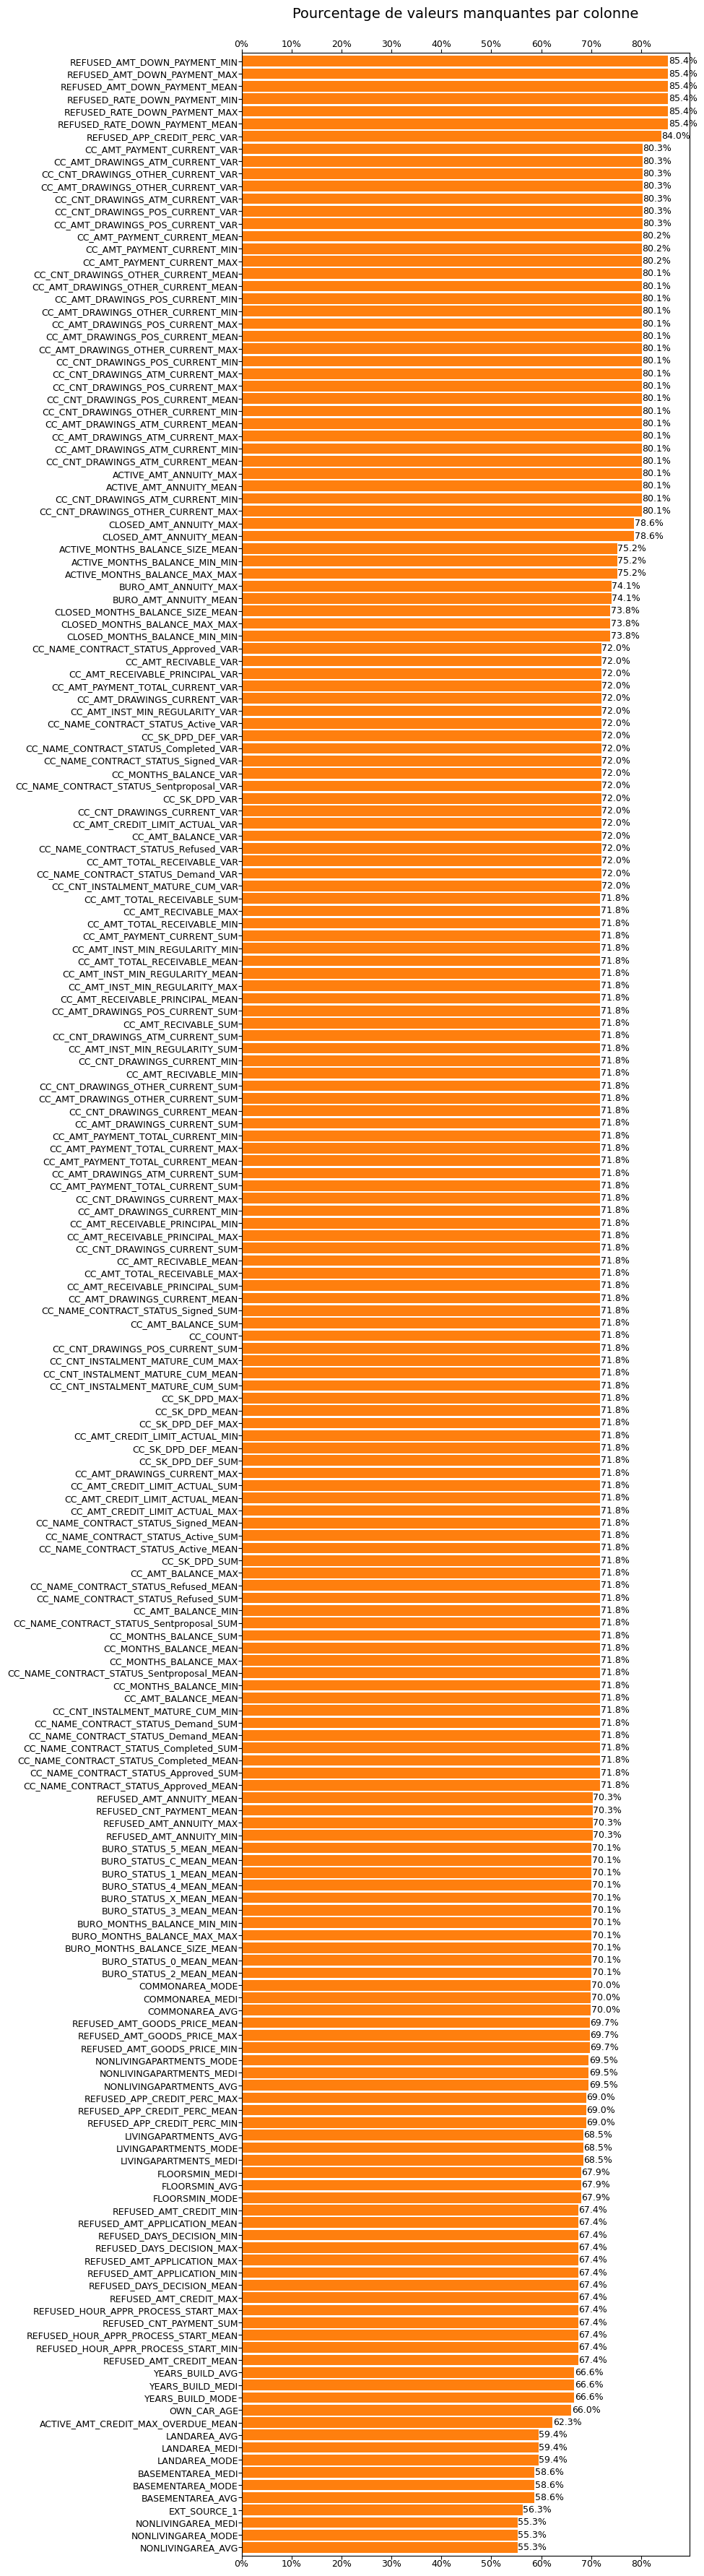

In [28]:
missing_values_barh(df)

In [30]:
nvidia - smi

NameError: name 'nvidia' is not defined

In [29]:
corr = df.corr(method="spearman")

KeyboardInterrupt: 

In [23]:
ds.undersample_nearmiss()

ValueError: Input X contains NaN.
NearMiss does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

No re-sampling (A faire pour le dataset traité par le modèle fitté)